In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
from textblob import TextBlob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import log1p, isnan
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import os
import re

In [3]:
dbcon = pymongo.MongoClient(os.getenv('BAILY_MONGO_URI'))
video_fields = ["title","views_total", "views_per_hour", "created_time", "country"]
videos = pd.DataFrame(list(dbcon['chatbox-dev'].videos.find()), columns=video_fields).dropna()
print videos.count()
videos.head()

title             9998
views_total       9998
views_per_hour    9998
created_time      9998
country           9998
dtype: int64


,title,views_total,views_per_hour,created_time,country
0,Le tchat Facebook est encore plus simple depui...,6483800,165.186959,1333024241,
1,SK vs dignitas GRAND FINAL 99Damage Masters Pl...,6737329,430.931061,1418045182,DE
2,Discutez. Partagez. Soyez complices. Tout simp...,7053032,187.750597,1339091391,
3,Baby Panda Sneezing,24397134,1060.919978,1391542518,FR
4,ALLAH ka mojza,6594888,578.065872,1433258112,US


In [4]:
black_list = [
    'pdf',
    'download',
    'ebook',
    'online',
    'read',
    'full movie',
    'book',
    'buy',
    'fuck',
    'cams',
    'webcam',
    'boob',
    'sex',
    'follow',
]

regexes = [re.compile(' ' + word + ' ', re.IGNORECASE) for word in black_list]

In [5]:
url = r'([\da-z\.-]+\.[a-z\.]{2,6})'

index = 0
has_blacklist_words = []
title_lengths = []
title_caps_percents = []
link_counts = []
subjectivities = []
polarities = []
view_logs = []
hour_uploaded = []

texts = []

for i in range(len(videos)):
    
    title = videos.ix[i].title
    
    has_b = False
    for regex in regexes:
        if regex.search(title):
            has_b = True
            
    has_blacklist_words.append(has_b)
    texts.append(title)
            
    title_lengths.append(len(title))
    caps_count = float(sum(1 for c in title if c.isupper()))
    title_caps_percents.append(caps_count/float(len(title)))
    link_counts.append(len(re.findall(url, title)))
    
    tb = TextBlob(title)
    subjectivities.append(tb.sentiment.subjectivity)
    polarities.append(tb.sentiment.polarity)
    
    hour_uploaded
    
    lp = log1p(videos['views_total'][index])
    if not isnan(lp):
        view_logs.append(lp/10)
    else:
        view_logs.append(0)
            
    index = index + 1
    
videos['has_blacklist_words'] = has_blacklist_words
videos['title_length'] = title_lengths
videos['title_caps_percent'] = title_caps_percents
videos['link_count'] = link_counts
videos['subjectivity'] = subjectivities
videos['polarity'] = polarities
videos['views_score'] = view_logs


In [6]:
videos.corr()

,views_total,views_per_hour,created_time,has_blacklist_words,title_length,title_caps_percent,link_count,subjectivity,polarity,views_score
views_total,1.000000,0.514769,0.034341,0.006058,0.005190,0.011005,-0.025188,0.021160,0.028835,0.607677
views_per_hour,0.514769,1.000000,0.262845,-0.000584,0.035396,-0.008691,-0.043153,0.026565,0.023839,0.402381
created_time,0.034341,0.262845,1.000000,0.028395,0.286858,-0.042318,-0.080120,0.143304,0.080716,0.077324
has_blacklist_words,0.006058,-0.000584,0.028395,1.000000,0.089486,0.015903,0.011518,0.074337,0.076787,0.018838
title_length,0.005190,0.035396,0.286858,0.089486,1.000000,0.112844,0.060549,0.285106,0.130600,0.015322
title_caps_percent,0.011005,-0.008691,-0.042318,0.015903,0.112844,1.000000,-0.049117,0.111080,0.040124,0.023835
link_count,-0.025188,-0.043153,-0.080120,0.011518,0.060549,-0.049117,1.000000,-0.051260,-0.012006,-0.065437
subjectivity,0.021160,0.026565,0.143304,0.074337,0.285106,0.111080,-0.051260,1.000000,0.353229,0.026088
polarity,0.028835,0.023839,0.080716,0.076787,0.130600,0.040124,-0.012006,0.353229,1.000000,0.024087
views_score,0.607677,0.402381,0.077324,0.018838,0.015322,0.023835,-0.065437,0.026088,0.024087,1.000000


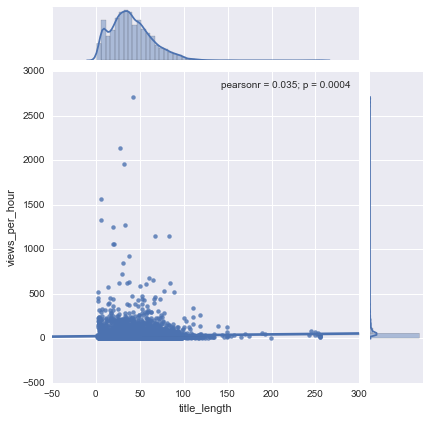

In [7]:
sns.jointplot(y='views_per_hour', x='title_length', data=videos, kind="reg")

In [8]:
videos.views_per_hour.describe()

count    9998.000000
mean       27.580600
std        69.799420
min         1.886071
25%         6.703339
50%        12.887659
75%        26.253145
max      2705.214341
Name: views_per_hour, dtype: float64

In [9]:
views_level = []

for i in range(0,len(videos)):
    if(videos.ix[i].views_per_hour > 1000):
        views_level.append(13)
    elif(videos.ix[i].views_per_hour > 200):
        views_level.append(12)
    elif(videos.ix[i].views_per_hour > 50):
        views_level.append(11)
    elif(videos.ix[i].views_per_hour > 40):
        views_level.append(10)
    elif(videos.ix[i].views_per_hour > 30):
        views_level.append(9)
    elif(videos.ix[i].views_per_hour > 20):
        views_level.append(8)
    elif(videos.ix[i].views_per_hour > 10):
        views_level.append(7)
    elif(videos.ix[i].views_per_hour > 8):
        views_level.append(6)
    elif(videos.ix[i].views_per_hour > 6):
        views_level.append(5)
    elif(videos.ix[i].views_per_hour > 4):
        views_level.append(4)
    elif(videos.ix[i].views_per_hour > 2):
        views_level.append(3)
    elif(videos.ix[i].views_per_hour > 1):
        views_level.append(2)
    elif(videos.ix[i].views_per_hour > 0.5):
        views_level.append(1)
    else:
        views_high.append(0)


videos['views_level'] = views_level
videos['views_level'].describe()

count    9998.000000
mean        6.793559
std         2.377538
min         2.000000
25%         5.000000
50%         7.000000
75%         8.000000
max        13.000000
Name: views_level, dtype: float64

In [10]:
videos_ts_index = pd.to_datetime(videos['created_time'],unit="s")
videos['time_index'] = videos_ts_index
videos_ts = videos.set_index('time_index')
videos_ts.head()

,title,views_total,views_per_hour,created_time,country,has_blacklist_words,title_length,title_caps_percent,link_count,subjectivity,polarity,views_score,views_level
time_index,,,,,,,,,,,,,
2012-03-29 12:30:41,Le tchat Facebook est encore plus simple depui...,6483800,165.186959,1333024241,,False,57,0.052632,0,0.357143,0.00,1.568482,11
2014-12-08 13:26:22,SK vs dignitas GRAND FINAL 99Damage Masters Pl...,6737329,430.931061,1418045182,DE,False,55,0.272727,0,1.000000,0.25,1.572317,12
2012-06-07 17:49:51,Discutez. Partagez. Soyez complices. Tout simp...,7053032,187.750597,1339091391,,False,53,0.075472,0,0.000000,0.00,1.576897,11
2014-02-04 19:35:18,Baby Panda Sneezing,24397134,1060.919978,1391542518,FR,False,19,0.157895,0,0.000000,0.00,1.700998,13
2015-06-02 15:15:12,ALLAH ka mojza,6594888,578.065872,1433258112,US,False,14,0.357143,0,0.000000,0.00,1.570181,12


In [11]:
m1 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(penalty='l1', C=10))
])
m1.fit(videos['title'], videos['views_level'])

m2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(penalty='l1', C=10))
])
m2.fit(videos['title'], videos['has_blacklist_words'])

Pipeline(steps=[('vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_id...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [12]:
vec, clf = m1.named_steps['vectorizer'], m1.named_steps['classifier']
coefs = pd.Series(clf.coef_[0], index=vec.get_feature_names())
print("\n20 most discriminating words:")
print(coefs[coefs.abs().sort_values(ascending=False).index][:40])


20 most discriminating words:
türkiyem      1.622557e+01
octopus       1.601214e+01
pas           1.421971e+01
maradona      1.341686e+01
mario         1.193783e+01
jerome        1.159743e+01
s01e04        1.151880e+01
rated         1.130200e+01
raise         1.091114e+01
depeche       9.390475e+00
backstreet    9.123092e+00
litre         9.079748e+00
sex           8.850643e+00
spice         8.679066e+00
lebanner      8.375513e+00
people        7.938260e+00
call          7.293317e+00
stop          6.949888e+00
inglaterra    6.589540e+00
mariah        6.103851e+00
uk            5.884684e+00
christmas     5.872571e+00
vjs           5.381618e+00
carey         5.171844e+00
you           4.633684e+00
want          3.408740e+00
body          2.489318e+00
me            1.776505e+00
let           1.096063e+00
sapp          7.258797e-01
vu            6.718195e-01
funny        -3.147315e-01
office        2.092875e-01
hot          -9.802888e-03
pris          5.228605e-07
interdit      3.561696e-

In [13]:
from sklearn.externals import joblib

joblib.dump({'video_views_predictor': m1, 'is_spam': m2}, './_models/video-trend', compress=9)

['models']

In [22]:
p = float(m2.predict(['trump'])[0])
p

0.0